In [126]:
import struct
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# create dictionaries to store the data
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
train = dict()
test = dict()

In [4]:
def get_images(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        print(magic, size, rows, cols)
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape (size, rows, cols)

In [5]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

2051 60000 28 28
2051 10000 28 28
(60000, 28, 28) (10000, 28, 28)


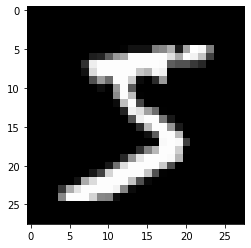

In [6]:
fig , ax = plt.subplots()
ax.imshow(train['image'][0], cmap = 'gray')

In [7]:
def get_labels(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read( 8 ))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [8]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


In [10]:
#check that labels are between expected values
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [20]:
print(train['image'][0].shape)

(28, 28)


**"Without any assumptions on the noise, the linear least squares solution for any i.i.d. sample will typically be biased w.r.t. the least squares optimum over the entire distribution. However, we show that if an i.i.d. sample of any size k is augmented by a certain small additional sample, then the solution of the combined sample becomes unbiased."** In this case I called that vector $\beta_0 $ so that:
\Y(X) =
  \begin{cases}
    1       & \quad\ X^{T}\beta + \beta_0 = k\\
    -1  & \quad\ X^{T}\beta + \beta_0 \neq k
  \end{cases}
\


$k \in [0,1, 2, ..., 9]$

but if we incorporate a zeroth column of 1's into  X we can likewise include $\beta_0$ in the complete coefficient vector $\beta$ and write our model in the more compact form:

$
Y(X) = X^T \beta
$

In this case $\beta$ will determine the equation of the line given by Y so

$
\beta = (X^T X)^{-1}X^TY 
$

 


In [92]:
def oneD_bias_img(image):
    #create a zero array and makes images 1D
    flat = np.zeros((image.shape[0], np.product(image.shape[1:])))
    for i in range(flat.shape[0]):
        flat[i] = image[i].flatten()
    #adds a column of 1's to prevent bias for i.i.d r.v.
    unbias_array = np.concatenate([flat, np.ones((flat.shape[0], 1))], axis=1)
    return unbias_array
    
def binary_response(labels, number):
    """takes the labels array and a number you would like the model to recognize
    it returns an array of 1 and -1 depending if the target value was found"""
    binary_col = np.zeros((labels.shape[0], 1))   
    for i in range(binary_col.shape[0]):
        
        if labels[i] == number:
            binary_col[i] = 1
        else:
            binary_col[i] = -1
    return binary_col
def beta(x, y):
    b = np.matmul(np.linalg.pinv(np.matmul(x.transpose(), x)), np.matmul(x.transpose(), y))
    return b

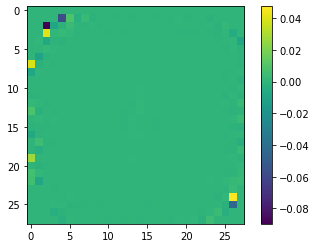

In [100]:
x = oneD_bias_img(train['image'])
y = binary_response(train['label'], 1)
betaa  = beta(x,y)
p = (betaa[:784, 0].reshape(28,28)) #not sure what this has to be like this??
ax = plt.imshow(p)
plt.colorbar(ax)

Now that I have my images in an array and my response variable in binary form I would like to normalize my
data to better fit it into my model. I'm using sklearn.preprocessing package and I'm using a pipeline to standarized and plug into my model at once.


In [103]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x, y)

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [121]:
test_x = oneD_bias_img(test['image'])
y_pred =pipe.predict(test_x)

In [122]:
result = pipe.predict(oneD_bias_img(test['image']))

In [123]:
y1 = binary_labels(test['label'], 0)

In [124]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(pipe.score(x, y)))

Accuracy of logistic regression classifier on test set: 0.99


Below is the confusion matrix for k = 0. 

In [127]:
confusion_matrixx = confusion_matrix(y1, y_pred)
print(type(confusion_matrixx))

<class 'numpy.ndarray'>


In [131]:
print(confusion_matrixx)

[[7873 1147]
 [ 980    0]]


In [133]:
print(f"True Positive = {confusion_matrixx[0,0]}, False Positive = {confusion_matrixx[1,0]}, \
False Negative = {confusion_matrixx[0,1]}, and True Negative = {confusion_matrixx[1,1]}")

True Positive = 7873, False Positive = 980, False Negative = 1147, and True Negative = 0
